# 8-2 합성곱 신경망을 이용한 이미지 분류
학습 목표 : 케라스 API를 사용해 합성곱 신경망 모델을 만들어 패션 MNIST 이미지를 분류하는 방법을 배움<br>
핵심 키워드 : Conv2d, MexPooling2D, plot_model

## 패션 MNIST 데아터 불러오기

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
# Conv2D 층을 사용하기 위해 마지막에 채널 차원을 추가해줌
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


## 합성곱 신경망 만들기

### 첫 번째 합성곱-폴링 층

In [ ]:
model = keras.Sequential()
# 32개의 필터를 사용하고 커널의 크기가 (3, 3)이고 렐루 활성화 함수와 세임 패딩을 사용
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))
# (2, 2) 크기의 풀링 층 추가
model.add(keras.layers.MaxPooling2D(2))

패션 MNIST 이미지 (28, 28) 크기 <br>
→ 32개의 필터, 세임 패딩 합성곱 = (28, 28, 32) 크기 <br>
→ (2, 2) 폴링 = (14, 14, 28) 크기

### 두 번째 합성곱-폴링 층

In [ ]:
# 64개의 필터를 사용하고 커널의 크기가 (3, 3)이고 렐루 활성화 함수와 세임 패딩을 사용
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

(14, 14, 32) → (7, 7, 64)

### 완전 연결층

In [ ]:
# 3차원 특성 맵을 일렬로 펼침 - 마지막 10개의 뉴런을 가진 (밀집) 출력 층에서 확률을 계산하기 때문
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

### 모델 구조 출력

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

### 층의 구성 그림 출력

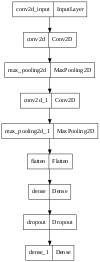

In [ ]:
keras.utils.plot_model(model, dpi=30)

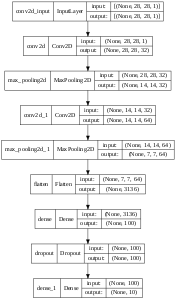

In [ ]:
# show_shapes 매개변수 : input, output 크기 표시
# to_file 매개변수 : 파일로 저장
# dpi 매개변수 : 해상도 지정
keras.utils.plot_model(model, show_shapes=True, dpi=30)

## 모델 컴파일과 훈련

Adam 옵티마이저를 사용하고 ModelCheckpoint 콜백과 EarlyStopping 콜백을 함께 사용해 조기 종료 기법 구현

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 69s 45ms/step - loss: 0.5165 - accuracy: 0.8150 - val_loss: 0.3280 - val_accuracy: 0.8777
Epoch 2/20
1500/1500 [==============================] - 69s 46ms/step - loss: 0.3451 - accuracy: 0.8769 - val_loss: 0.2924 - val_accuracy: 0.8894
Epoch 3/20
1500/1500 [==============================] - 70s 47ms/step - loss: 0.2981 - accuracy: 0.8921 - val_loss: 0.2497 - val_accuracy: 0.9075
Epoch 4/20
1500/1500 [==============================] - 67s 45ms/step - loss: 0.2665 - accuracy: 0.9033 - val_loss: 0.2447 - val_accuracy: 0.9097
Epoch 5/20
1500/1500 [==============================] - 66s 44ms/step - loss: 0.2403 - accuracy: 0.9125 - val_loss: 0.2289 - val_accuracy: 0.9143
Epoch 6/20
1500/1500 [==============================] - 66s 44ms/step - loss: 0.2214 - accuracy: 0.9187 - val_loss: 0.2275 - val_accuracy: 0.9178
Epoch 7/20
1500/1500 [==============================] - 67s 44ms/step - loss: 0.2047 - accuracy: 0.9241 - val_loss: 0.2174 -

### 손실 그래프 출력

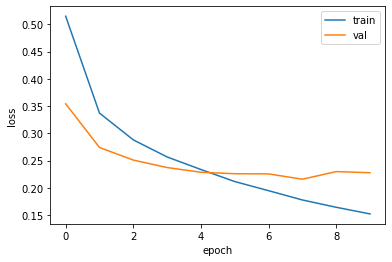

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

검증 세트에 대한 손실이 점차 감소하다가 정체되기 시작하고<br>
훈련 세트에 대한 손실은 점점 더 낮아진다<br>
=> 7번째 에포크가 최적

### 세트에 대한 성능 평가

In [ ]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.2157 - accuracy: 0.9237


[0.21573209762573242, 0.9237499833106995]

## 이미지 출력

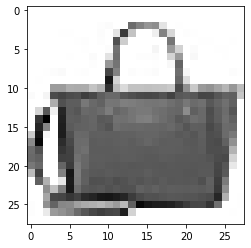

In [14]:
# (28, 28, 1) 크기를 (28, 28)로 바꾸어 출력
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

### 10개의 클래스에 대한 예측 확률 출력

In [15]:
preds = model.predict(val_scaled[0:1])
print(preds)

[[4.6872666e-22 1.8891609e-27 1.1501762e-23 3.6192177e-24 5.4211107e-21
  1.1133403e-22 4.4745472e-23 1.7918368e-21 1.0000000e+00 4.2896823e-27]]


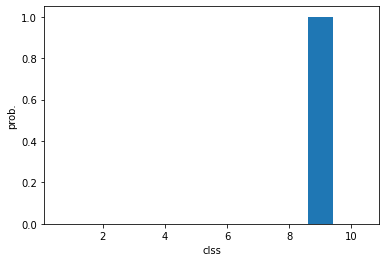

In [16]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('clss')
plt.ylabel('prob.')
plt.show()

In [17]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

import numpy as np
print(classes[np.argmax(preds)])

가방


### 테스트 세트 검증

In [18]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 3ms/step - loss: 0.2407 - accuracy: 0.9164


[0.24067607522010803, 0.9164000153541565]